In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import kagglehub

2026-01-18 04:18:40.994880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 04:18:41.044614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-18 04:18:42.597405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
DATASET_ID = "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"

data_path = kagglehub.dataset_download(DATASET_ID)


In [3]:
classes = {0:'Speed limit (20km/h)',
           1:'Speed limit (30km/h)', 
           2:'Speed limit (50km/h)', 
           3:'Speed limit (60km/h)', 
           4:'Speed limit (70km/h)', 
           5:'Speed limit (80km/h)', 
           6:'End of speed limit (80km/h)', 
           7:'Speed limit (100km/h)', 
           8:'Speed limit (120km/h)', 
           9:'No passing', 
           10:'No passing veh over 3.5 tons', 
           11:'Right-of-way at intersection', 
           12:'Priority road', 
           13:'Yield', 
           14:'Stop', 
           15:'No vehicles', 
           16:'Veh > 3.5 tons prohibited', 
           17:'No entry', 
           18:'General caution', 
           19:'Dangerous curve left', 
           20:'Dangerous curve right', 
           21:'Double curve', 
           22:'Bumpy road', 
           23:'Slippery road', 
           24:'Road narrows on the right', 
           25:'Road work', 
           26:'Traffic signals', 
           27:'Pedestrians', 
           28:'Children crossing', 
           29:'Bicycles crossing', 
           30:'Beware of ice/snow', 
           31:'Wild animals crossing', 
           32:'End speed + passing limits', 
           33:'Turn right ahead', 
           34:'Turn left ahead', 
           35:'Ahead only', 
           36:'Go straight or right', 
           37:'Go straight or left', 
           38:'Keep right', 
           39:'Keep left', 
           40:'Roundabout mandatory', 
           41:'End of no passing', 
           42:'End no passing veh > 3.5 tons'}

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "Train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "Test.csv"))

train_df['Path'] = train_df['Path'].apply(
    lambda p: os.path.join(data_path, p)
)
test_df['Path'] = test_df['Path'].apply(
    lambda p: os.path.join(data_path, p)
)

train_df['ClassId'] = train_df['ClassId'].astype(int)
train_df['ClassName'] = train_df['ClassId'].map(classes)

In [5]:
##EDA

In [6]:
# 1. Check for missing values (Rubric requirement)
print(f"Missing values:\n{train_df.isnull().sum()}")

Missing values:
Width        0
Height       0
Roi.X1       0
Roi.Y1       0
Roi.X2       0
Roi.Y2       0
ClassId      0
Path         0
ClassName    0
dtype: int64


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Width      39209 non-null  int64 
 1   Height     39209 non-null  int64 
 2   Roi.X1     39209 non-null  int64 
 3   Roi.Y1     39209 non-null  int64 
 4   Roi.X2     39209 non-null  int64 
 5   Roi.Y2     39209 non-null  int64 
 6   ClassId    39209 non-null  int64 
 7   Path       39209 non-null  object
 8   ClassName  39209 non-null  object
dtypes: int64(7), object(2)
memory usage: 2.7+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


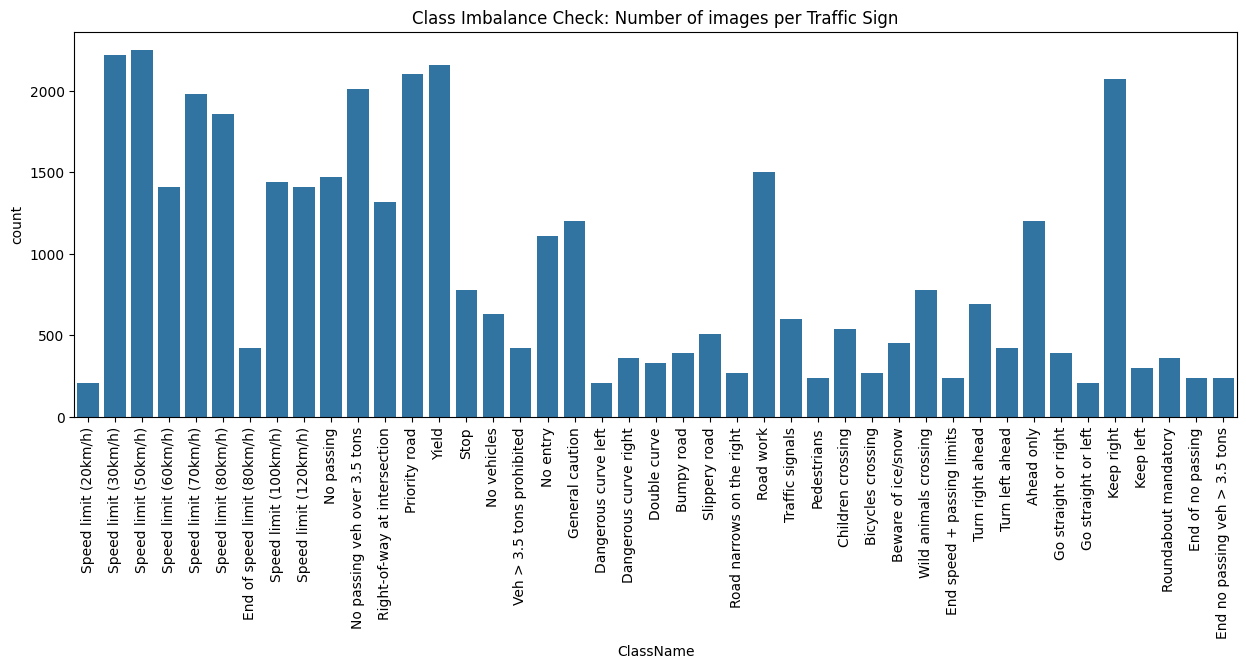

In [9]:
# 2. Analysis of Target Variable (Class Distribution)
plt.figure(figsize=(15, 5))
sns.countplot(x='ClassName', data=train_df, order=list(classes.values()))
plt.title('Class Imbalance Check: Number of images per Traffic Sign')
plt.xticks(rotation=90)
plt.show()

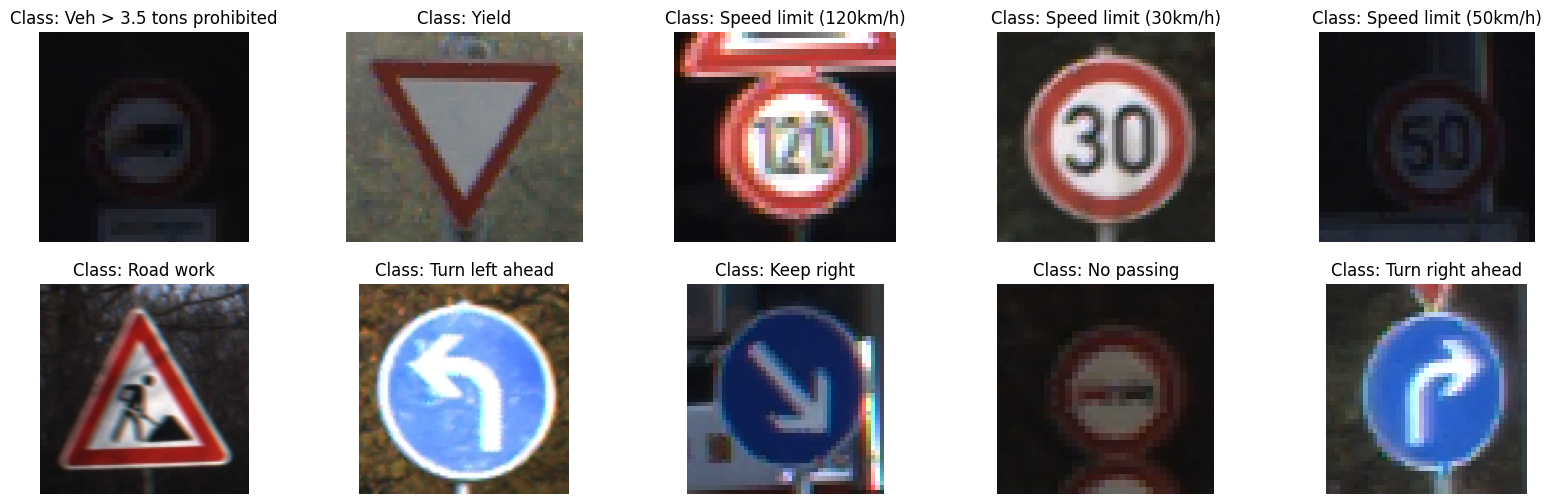

In [10]:
# 3. Content Analysis: Visualize 5 random signs
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sample = train_df.sample(1)
    img = Image.open(sample['Path'].values[0])
    plt.imshow(img)
    plt.title(f"Class: {sample['ClassName'].values[0]}")
    plt.axis('off')
plt.show()

In [11]:
# 4. Feature Analysis: Image Width/Height ranges
print(f"Width Range: {train_df.Width.min()} to {train_df.Width.max()}")

Width Range: 25 to 243


In [12]:
# Split the train dataset to train_set and val_set

In [13]:
train_set, val_set = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=42)

In [14]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['ClassId']), y=train_df['ClassId'])
weights_dict = {i: w for i, w in enumerate(weights)}

In [15]:
print(train_set.info())
print(val_set.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31367 entries, 19308 to 16219
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Width      31367 non-null  int64 
 1   Height     31367 non-null  int64 
 2   Roi.X1     31367 non-null  int64 
 3   Roi.Y1     31367 non-null  int64 
 4   Roi.X2     31367 non-null  int64 
 5   Roi.Y2     31367 non-null  int64 
 6   ClassId    31367 non-null  int64 
 7   Path       31367 non-null  object
 8   ClassName  31367 non-null  object
dtypes: int64(7), object(2)
memory usage: 2.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7842 entries, 31217 to 19586
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Width      7842 non-null   int64 
 1   Height     7842 non-null   int64 
 2   Roi.X1     7842 non-null   int64 
 3   Roi.Y1     7842 non-null   int64 
 4   Roi.X2     7842 non-null   int64 
 5   Roi.Y2     7842 non-null 

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.5, 1.5]
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_gen = train_datagen.flow_from_dataframe(train_set, x_col='Path', y_col='ClassId', target_size=(32,32), batch_size=32, class_mode='raw')
val_gen = val_datagen.flow_from_dataframe(val_set, x_col='Path', y_col='ClassId', target_size=(32,32), batch_size=32, class_mode='raw')

Found 31367 validated image filenames.
Found 7842 validated image filenames.


In [18]:
from tensorflow.keras import layers, models, optimizers

def build_experiment_model(inner_size=128, drop_rate=0.0, lr=0.001):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(inner_size, activation='relu'))
    
    if drop_rate > 0:
        model.add(layers.Dropout(drop_rate))
        
    model.add(layers.Dense(43, activation='softmax'))
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

all_results = []

In [19]:
def build_tuned_model(inner_size=128, drop_rate=0.0, lr=0.001):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(inner_size, activation='relu')
    ])
    
    if drop_rate > 0:
        model.add(layers.Dropout(drop_rate))
        
    model.add(layers.Dense(43, activation='softmax'))
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

best_size = 128
best_drop = 0.5
best_lr = 0.001

tuning_results = {}

# Model with no dropout
baseline_model = build_tuned_model(inner_size=best_size, drop_rate=0.0, lr=best_lr)
h_base = baseline_model.fit(train_gen, validation_data=val_gen, epochs=5, class_weight=weights_dict, verbose=1)
tuning_results['Baseline (No Drop)'] = max(h_base.history['val_accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-18 04:18:46.884496: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 69s 67ms/step - accuracy: 0.3265 - loss: 2.3164 - val_accuracy: 0.6331 - val_loss: 1.0735
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.6424 - loss: 1.0737 - val_accuracy: 0.8315 - val_loss: 0.5195
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.7551 - loss: 0.6955 - val_accuracy: 0.8785 - val_loss: 0.3774
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.8080 - loss: 0.5101 - val_accuracy: 0.9064 - val_loss: 0.3036
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.8422 - loss: 0.4146 - val_accuracy: 0.9413 - val_loss: 0.2065


Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.1400 - loss: 3.0813 - val_accuracy: 0.4492 - val_loss: 1.9744
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.2878 - loss: 2.2270 - val_accuracy: 0.5682 - val_loss: 1.4028
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.3766 - loss: 1.8475 - val_accuracy: 0.6781 - val_loss: 1.0291
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.4297 - loss: 1.6281 - val_accuracy: 0.7042 - val_loss: 0.9471
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.4704 - loss: 1.4657 - val_accuracy: 0.7288 - val_loss: 0.8019
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.2050 - loss: 2.7858 - val_accuracy: 0.5360 - val_loss: 1.4712
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4224 - loss: 1.7812 - val_accuracy: 0.6631 - val_loss: 1.0168
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.5190 - loss: 1.3752 - val_accu

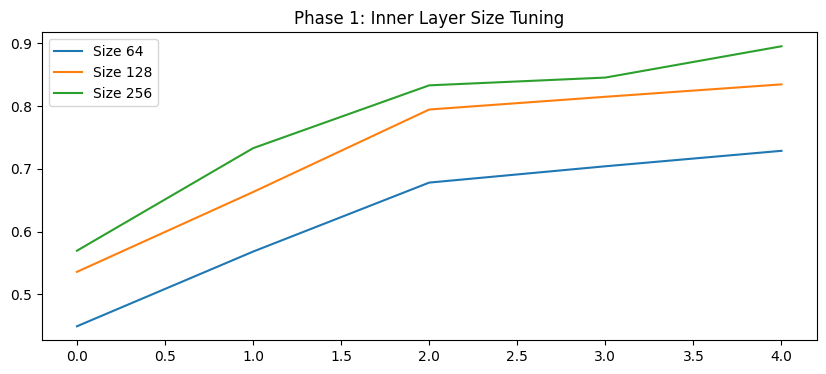

In [20]:
# Models with different inner size
sizes = [64, 128, 256]
size_scores = {}

plt.figure(figsize=(10, 4))
for s in sizes:
    m = build_tuned_model(inner_size=s, drop_rate=best_drop, lr=best_lr)
    h = m.fit(train_gen, validation_data=val_gen, epochs=5, class_weight=weights_dict, verbose=1)
    acc = max(h.history['val_accuracy'])
    size_scores[s] = acc
    plt.plot(h.history['val_accuracy'], label=f'Size {s}')


best_size = max(size_scores, key=size_scores.get)
print(f"Inner Size = {best_size}")
plt.title('Phase 1: Inner Layer Size Tuning'); plt.legend(); plt.show()


>>> Inherited Best Size: 256, Current LR: 0.001
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.3272 - loss: 2.2975 - val_accuracy: 0.7020 - val_loss: 0.9787
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.6336 - loss: 1.0715 - val_accuracy: 0.8346 - val_loss: 0.4935
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.7289 - loss: 0.7408 - val_accuracy: 0.8815 - val_loss: 0.3661
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.7857 - loss: 0.5526 - val_accuracy: 0.9234 - val_loss: 0.2416
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.8169 - loss: 0.4597 - val_accuracy: 0.9444 - val_loss: 0.1824
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.2579 - loss: 2.5484 - val_accuracy: 0.6067 - val_loss: 1.2868
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.5492 - loss: 1.3593 - val_accuracy: 0.8143 - val_loss: 0.6596
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/

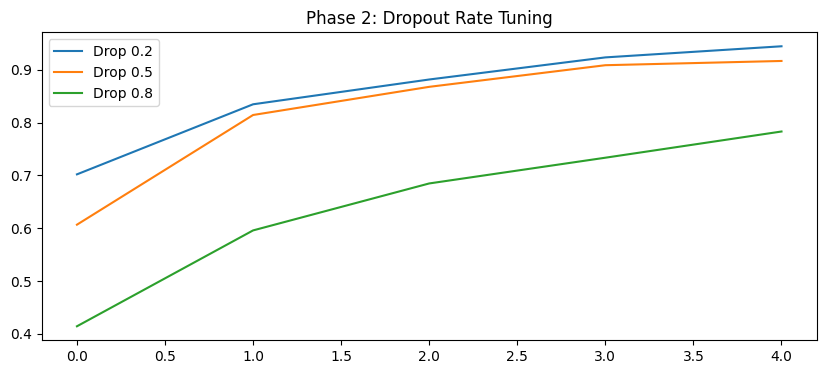

In [21]:
# Models with different dropout rates
print(f"\n>>> Inherited Best Size: {best_size}, Current LR: {best_lr}")
rates = [0.2, 0.5, 0.8]
drop_scores = {}

plt.figure(figsize=(10, 4))
for r in rates:
    m = build_tuned_model(inner_size=best_size, drop_rate=r, lr=best_lr)
    h = m.fit(train_gen, validation_data=val_gen, epochs=5, class_weight=weights_dict, verbose=1)
    acc = max(h.history['val_accuracy'])
    drop_scores[r] = acc
    plt.plot(h.history['val_accuracy'], label=f'Drop {r}')

best_drop = max(drop_scores, key=drop_scores.get)
print(f"WINNER: Dropout Rate = {best_drop}")
plt.title('Phase 2: Dropout Rate Tuning'); plt.legend(); plt.show()


>>> Inherited Size: 256, Inherited Drop: 0.2
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.0117 - loss: 3.7677 - val_accuracy: 0.0115 - val_loss: 3.7680
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.0099 - loss: 3.7658 - val_accuracy: 0.0069 - val_loss: 3.7521
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.0193 - loss: 3.7659 - val_accuracy: 0.0092 - val_loss: 3.7682
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.0154 - loss: 3.7661 - val_accuracy: 0.0199 - val_loss: 3.7678
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.0128 - loss: 3.7657 - val_accuracy: 0.0199 - val_loss: 3.7583
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3190 - loss: 2.3558 - val_accuracy: 0.6455 - val_loss: 1.0773
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.6294 - loss: 1.0927 - val_accuracy: 0.8280 - val_loss: 0.5261
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/ste

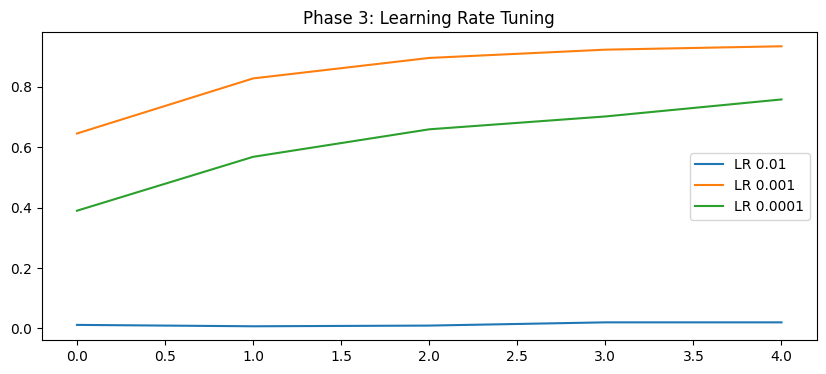

In [22]:
# Models with different learning rate
print(f"\n>>> Inherited Size: {best_size}, Inherited Drop: {best_drop}")
lrs = [0.01, 0.001, 0.0001]
lr_scores = {}

plt.figure(figsize=(10, 4))
for l in lrs:
    m = build_tuned_model(inner_size=best_size, drop_rate=best_drop, lr=l)
    h = m.fit(train_gen, validation_data=val_gen, epochs=5, class_weight=weights_dict, verbose=1)
    acc = max(h.history['val_accuracy'])
    lr_scores[l] = acc
    plt.plot(h.history['val_accuracy'], label=f'LR {l}')

best_lr = max(lr_scores, key=lr_scores.get)
print(f"WINNER: Learning Rate = {best_lr}")
plt.title('Phase 3: Learning Rate Tuning'); plt.legend(); plt.show()

In [23]:
# Train the model with best parameter and more epochs
print(f"\n>>> Training FINAL MODEL with fully adapted parameters:")
print(f"Size: {best_size}, Drop: {best_drop}, LR: {best_lr}")

final_model = build_tuned_model(inner_size=best_size, drop_rate=best_drop, lr=best_lr)
final_history = final_model.fit(train_gen, validation_data=val_gen, epochs=20, class_weight=weights_dict)

final_model.save('traffic_sign_model.h5')
print("\nFinal tuned model saved as traffic_sign_model.h5")


>>> Training FINAL MODEL with fully adapted parameters:
Size: 256, Drop: 0.2, LR: 0.001
Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.3452 - loss: 2.2134 - val_accuracy: 0.7128 - val_loss: 0.8754
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.6746 - loss: 0.9459 - val_accuracy: 0.9013 - val_loss: 0.3472
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.7772 - loss: 0.6038 - val_accuracy: 0.9144 - val_loss: 0.2636
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 49s 50ms/step - accuracy: 0.8255 - loss: 0.4518 - val_accuracy: 0.9485 - val_loss: 0.1675
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.8566 - loss: 0.3647 - val_accuracy: 0.9490 - val_loss: 0.1634
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.8780 - loss: 0.3117 - val_accuracy: 0.9524 - val_loss: 0.1439
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.8928 - loss: 0.2699 - val_accuracy: 0.9694 - val_loss: 0.1006
E


Final tuned model saved as traffic_sign_model.h5


In [ ]:
if os.path.exists('traffic_sign_model.h5'):
    print("Loading existing model from disk...")
    final_model = tf.keras.models.load_model('traffic_sign_model.h5')
    print("Model loaded successfully!")
else:
    print("Model file not found. You must run the training block first.")

In [24]:
# Load test data
test_df['ClassId'] = test_df['ClassId'].astype(int)
test_df['ClassName'] = test_df['ClassId'].map(classes)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(32, 32),
    batch_size=32,
    class_mode='raw',
    shuffle=False  
)

Found 12630 validated image filenames.


In [25]:
#Use the model 
test_loss, test_acc = final_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9421 - loss: 0.2421
Test Accuracy: 94.21%


395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step

Classification Report:
                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.94      0.82      0.88        60
         Speed limit (30km/h)       0.95      0.95      0.95       720
         Speed limit (50km/h)       0.90      0.93      0.92       750
         Speed limit (60km/h)       0.85      0.93      0.89       450
         Speed limit (70km/h)       0.98      0.94      0.96       660
         Speed limit (80km/h)       0.89      0.89      0.89       630
  End of speed limit (80km/h)       0.97      0.91      0.94       150
        Speed limit (100km/h)       0.96      0.86      0.91       450
        Speed limit (120km/h)       0.88      0.95      0.91       450
                   No passing       0.93      0.97      0.95       480
 No passing veh over 3.5 tons       1.00      0.98      0.99       660
 Right-of-way at intersection       0.88      0.98      0.93       420
          

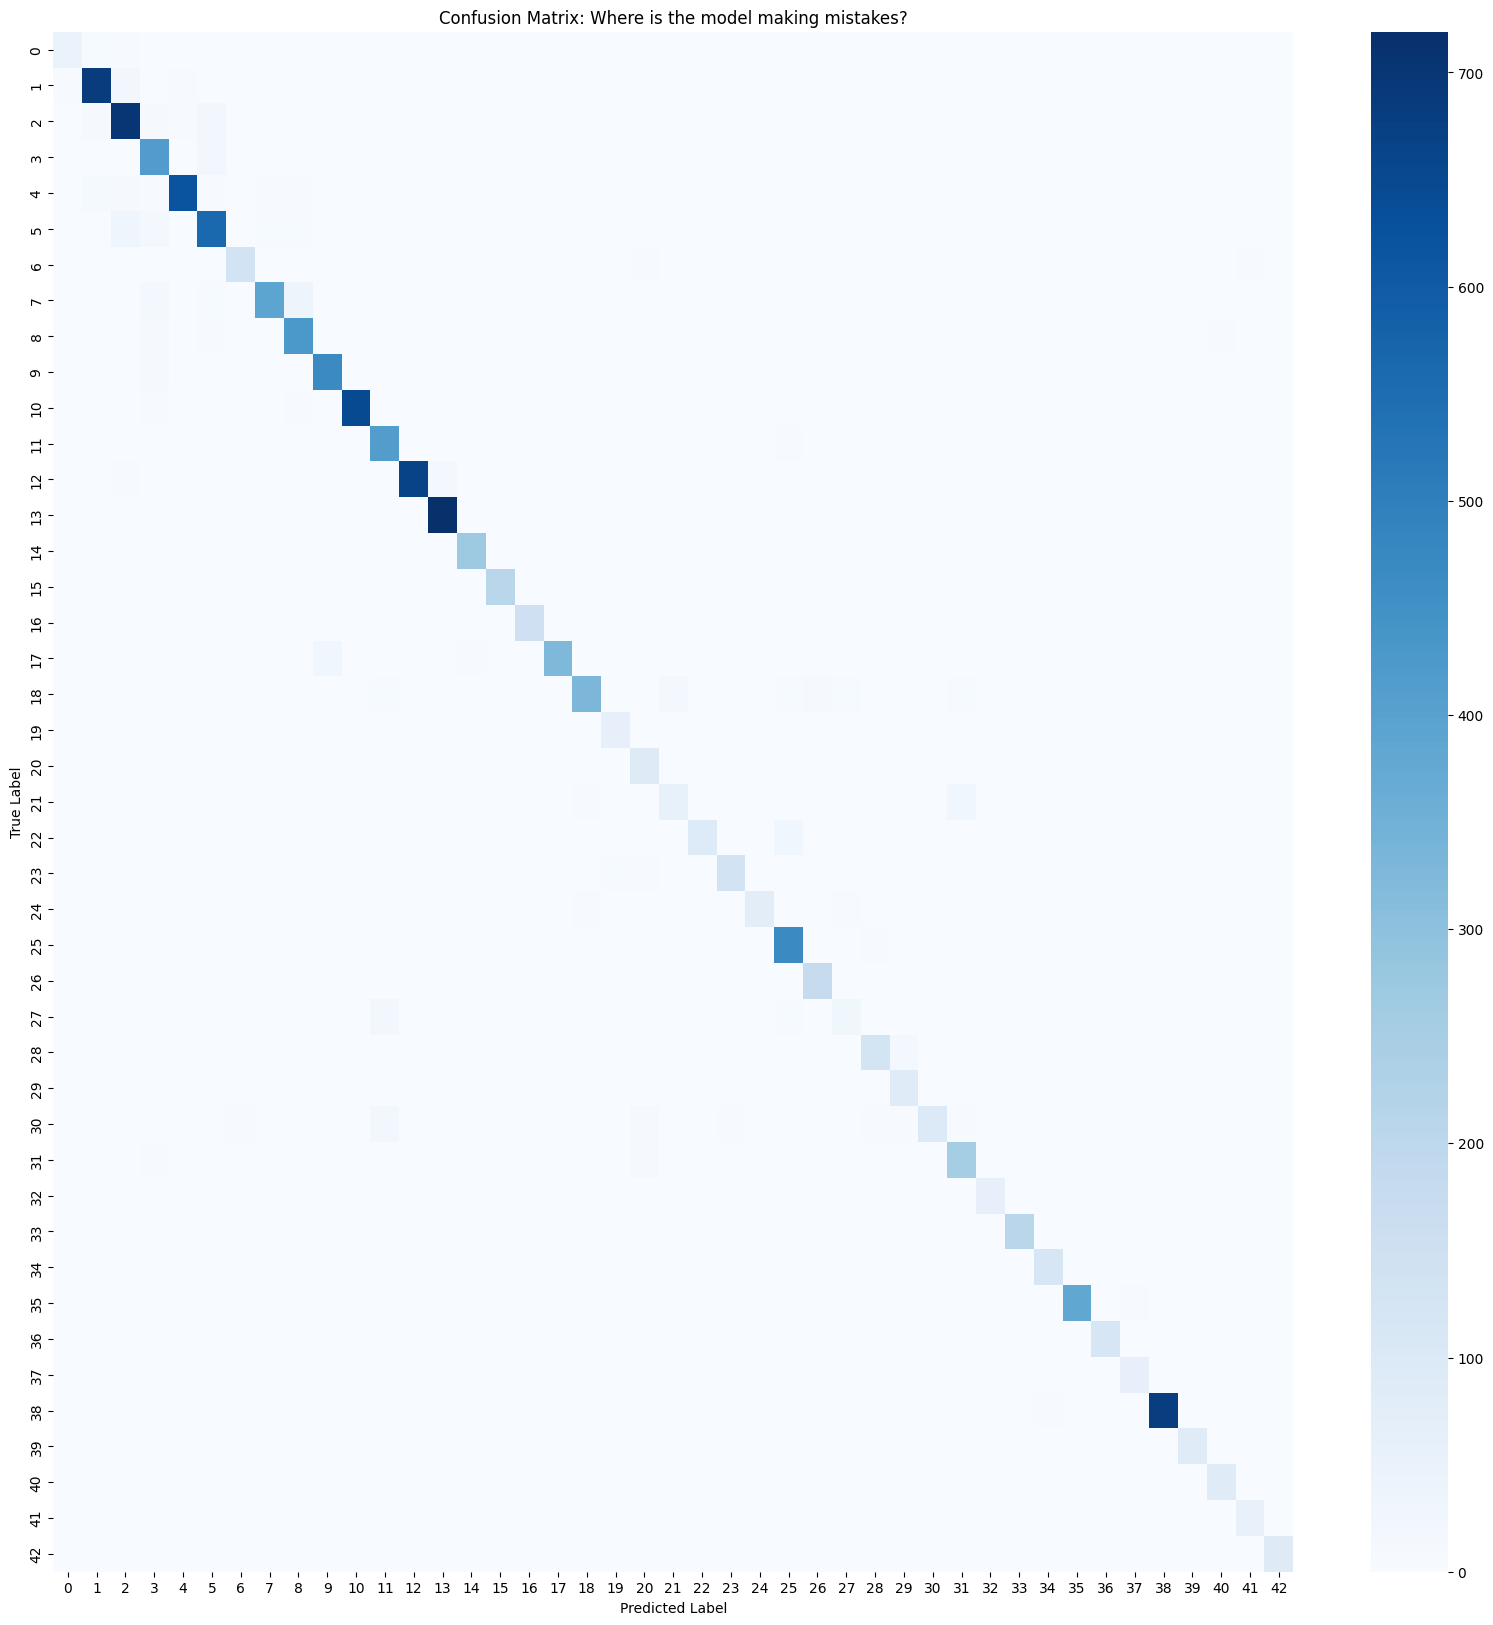

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred_probs = final_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_df['ClassId'].values

# 1. Print Classification Report
# This shows Precision, Recall, and F1-Score for the signs
target_names = [classes[i] for i in range(43)]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 2. Plot Confusion Matrix
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Where is the model making mistakes?')
plt.show()

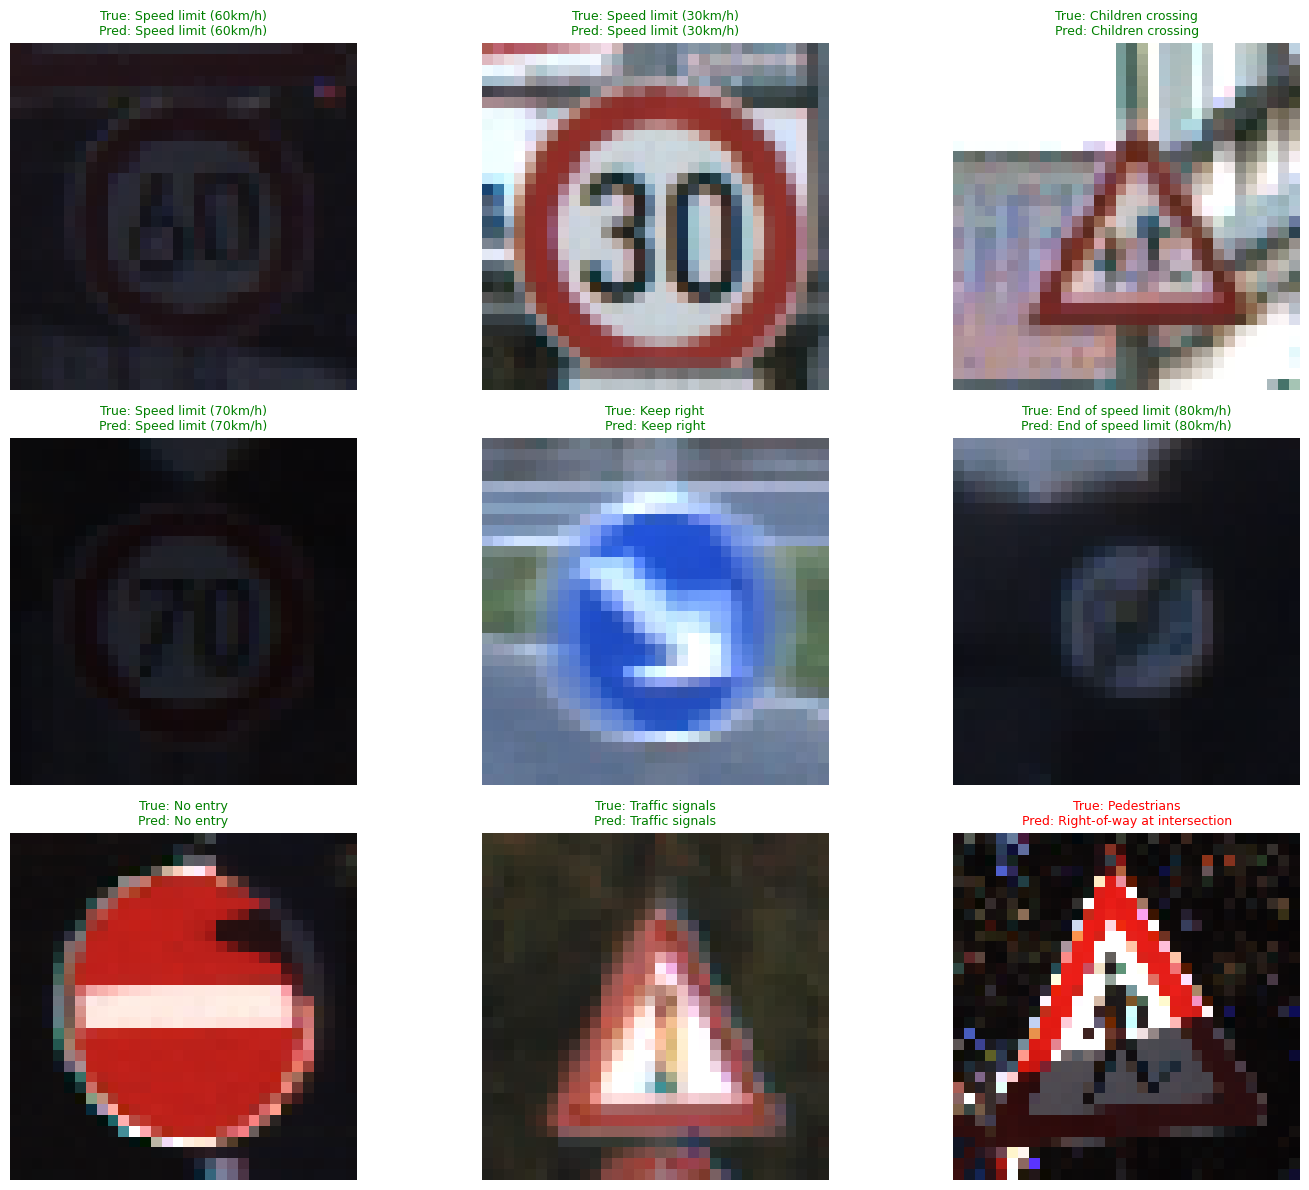

In [27]:
plt.figure(figsize=(15, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    
    # Get random image
    idx = np.random.randint(0, len(test_df))
    img_path = test_df.iloc[idx]['Path']
    true_id = int(test_df.iloc[idx]['ClassId'])
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred_probs = final_model.predict(img_array, verbose=0)
    pred_id = int(np.argmax(pred_probs))
    
    color = 'green' if pred_id == true_id else 'red'
    
    true_name = classes[true_id]
    pred_name = classes[pred_id]
    
    plt.imshow(img)
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [49]:
!uv pip compile pyproject.toml --python-version 3.11 -o uv.lock

Resolved 55 packages in 235ms                                        
# This file was autogenerated by uv via the following command:
#    uv pip compile pyproject.toml --python-version 3.11 -o uv.lock
absl-py==2.3.1
    # via
    #   keras
    #   tensorboard
    #   tensorflow-cpu
astunparse==1.6.3
    # via tensorflow-cpu
blinker==1.9.0
    # via flask
certifi==2026.1.4
    # via requests
charset-normalizer==3.4.4
    # via requests
click==8.3.1
    # via flask
flask==3.1.2
    # via traffic-sign-ai (pyproject.toml)
flatbuffers==25.12.19
    # via tensorflow-cpu
gast==0.7.0
    # via tensorflow-cpu
google-pasta==0.2.0
    # via tensorflow-cpu
grpcio==1.76.0
    # via
    #   tensorboard
    #   tensorflow-cpu
h5py==3.15.1
    # via
    #   keras
    #   tensorflow-cpu
idna==3.11
    # via requests
itsdangerous==2.2.0
    # via flask
jinja2==3.1.6
    # via flask
joblib==1.5.3
    # via scikit-learn
kagglehub==0.4.0
    # via traffic-sign-ai (pyproject.toml)
kagglesdk==0.1.15
    # vi

In [51]:
!docker rm -f traffic_service || true

!docker build -t traffic-sign-ai .

!docker run -d -p 9696:9696 --name traffic_service traffic-sign-ai

import time
print("Waiting 20 seconds for the new server to load the model...")
time.sleep(20)

!docker logs traffic_service

traffic_service

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.2s (2/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 424B                                       0.0s
 => WARN: FromAsCasing: 'as' and 'FROM' keywords' casing do not match (li  0.0s
 => [internal] load metadata for docker.io/library/python:3.11-slim        0.2s
 => [auth] library/python:pull token for registry-1.docker.io              0.0s
[+] Building 0.3s (2/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 424B                                       0.0s
 => WARN: FromAsCasing: 'as' and 'FROM' keywords' casing do not match (li  0.0s
 => [internal] load metadata for docker.io/library/python:3.11-slim        0.3s
 => [auth] library/pyth

In [52]:
!docker ps

CONTAINER ID   IMAGE             COMMAND               CREATED          STATUS          PORTS                                         NAMES
7d687281ca3f   traffic-sign-ai   "python predict.py"   45 seconds ago   Up 44 seconds   0.0.0.0:9696->9696/tcp, [::]:9696->9696/tcp   traffic_service


In [53]:
import requests

url = 'http://127.0.0.1:9696/predict'

dataset_id = "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
data_path = kagglehub.dataset_download(dataset_id)

# 2. Find a valid image path from the Test CSV
test_df = pd.read_csv(os.path.join(data_path, 'Test.csv'))

# Get the full path for the first image in the test set
sample_rel_path = test_df.iloc[0]['Path'] 
test_img_path = os.path.join(data_path, sample_rel_path)

print(f"Sending image to Docker: {test_img_path}")

# 3. Send the request to the local Docker container
try:
    with open(test_img_path, 'rb') as f:
        response = requests.post(url, files={'file': f})
    
    print("✅ Prediction Result:")
    print(response.json())
except Exception as e:
    print(f"❌ Still failing: {e}")
    print("Check !docker logs traffic_service again to see the error.")

Sending image to Docker: /home/codespace/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Test/00000.png
✅ Prediction Result:
{'class_id': 16, 'class_name': 'Veh > 3.5 tons prohibited', 'confidence': '100.00%'}


In [ ]:
# Stop the docker
!docker stop traffic_service
!docker rm traffic_service
print("Container stopped and cleaned up.")